Okay so in order to build everything from scratch, let's revisit the basics again, And the mathematical core of modern Deep Neural network libraries like pyTorch is that they implement backpropagation

Let's revisit what Backpropagation is.


In [212]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Let's write a simple function

In [213]:
def f(x):
    return 3*x**2 - 4*x + 5

In [214]:
f(3.0)

20.0

Let's define a range of values

In [215]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)


In [216]:
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [217]:
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

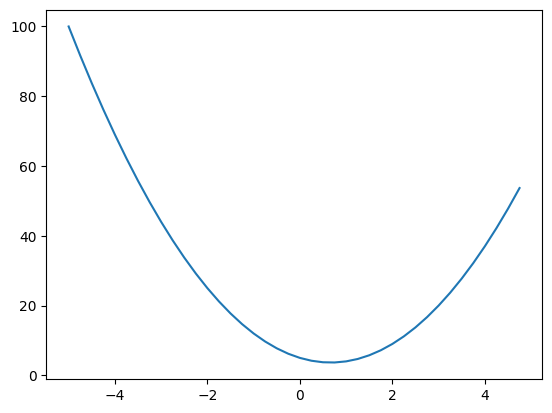

In [218]:
plt.plot(xs, ys)

In [219]:
h = 0.001
x = 3.0
print(f"(x, f(x)) = ({x}, {f(x)})")
# so if we slighly nudge x in positive direction, How is the function going to respond?
print(f"(x+h, f(x+h)) = ({x+h}, {f(x+h)})")

(x, f(x)) = (3.0, 20.0)
(x+h, f(x+h)) = (3.001, 20.014003000000002)


so f(x+h) is slightly greater than f(x) which was 20 and by how much is sort of teeling the strength of that slope

In [220]:
f(x+h) - f(x)

0.01400300000000243

This is how much the function responded in positive direction and we need to normalise it to get the slope

In [221]:
(f(x+h) - f(x))/h

14.00300000000243

This is just numerical approximation of slope as h needs to be very very small, but you can verify it by differentiating f(x) in your head and putting 3

In [222]:
h = 0.00000001
x = -3
print(f"(f(x+h) - f(x))/h =" , (f(x+h) - f(x))/h)

(f(x+h) - f(x))/h = -22.00000039920269


Let's dive a little deeper

In [223]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [224]:
h = 0.0001

# Inputs

a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
a = a + h
# b = b + h
# c = c + h
# each of the above lines will change the value of d2
d2 = a * b + c

print("d1 =", d1)
print("d2 =", d2)
print("slope =", (d2 - d1)/h)

d1 = 4.0
d2 = 3.999699999999999
slope = -3.000000000010772


slope shows the rate at which d2 will increase/decrease based on change in inputs

Now let's make Value object

In [225]:
# class Value:
#     def __init__(self,data):
#         self.data = data
#     def __repr__(self):
#         return f"Value(data={self.data})"

# a = Value(2.0)
# a

In [226]:
# # Now let's try adding two values, ofcourse it will fail as python currently doesn't know how to add two values

# a = Value(2.0)
# b = Value(-3.0)
# a + b

# # Now let's try adding two values, ofcourse it will fail as python currently doesn't know how to add two values

# a = Value(2.0)
# b = Value(-3.0)
# a + b

In [227]:
class Value:
    def __init__(self,data):
        self.data = data
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self, other):
        out = Value(self.data + other.data)
        return out
    # similarly we can define other operation like __mul__
    def __mul__(self, other):
        out = Value(self.data * other.data)
        return out

a = Value(2.0)
b = Value(-3.0)
print(f"a + b = {a + b}")
print(f"a * b = {a * b}")

a + b = Value(data=-1.0)
a * b = Value(data=-6.0)


In [228]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
a * b + c

Value(data=4.0)

So what are we missing out is the connecting tissue for this expression.. As we need to keep these expression graphs, so we need to keep pointer of what values produce what other values

In [229]:
class Value:
    def __init__(self,data, _children=()): # _children is a list of children and by default is an empty tuple
        self.data = data
        self._prev = set(_children) # for efficiency we will store the children in a set
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other))
        return out
    # similarly we can define other operation like __mul__
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other))
        return out

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a * b + c

In [230]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

So we know d is coming from a*b(-6) and c(10), i.e we know the children of every Value but we dont know what operation created this Value. So we should also keep the track of operator used.

In [231]:
class Value:

    def __init__(self,data, _children=(), _op=''): # _children is a list of children and by default is an empty tuple
        self.data = data
        self._prev = set(_children) # for efficiency we will store the children in a set
        self._op =  _op

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    # similarly we can define other operation like __mul__
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a * b + c

In [232]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [233]:
d._op

'+'

Okkay Let's visualise this.. We'll be using graphviz. Also in order for graph to not get confusing,let's add label

In [234]:
class Value:

    def __init__(self,data, _children=(), _op='', label=''): # _children is a list of children and by default is an empty tuple
        self.data = data
        self._prev = set(_children) # for efficiency we will store the children in a set
        self._op =  _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    # similarly we can define other operation like __mul__
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [235]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

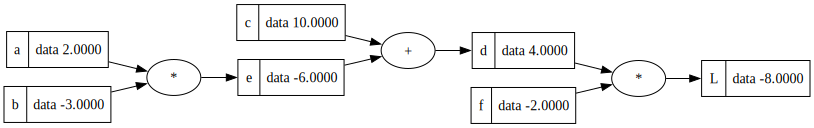

In [236]:
draw_dot(L)

![Forward Pass and Backpropagation](Images/ForwardPass&BackProp.png)

### So let's add grad in Value

In [237]:
class Value:

    def __init__(self,data, _children=(), _op='', label=''): # _children is a list of children and by default is an empty tuple
        self.data = data
        self.grad = 0
        self._prev = set(_children) # for efficiency we will store the children in a set
        self._op =  _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    # similarly we can define other operation like __mul__
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [238]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot



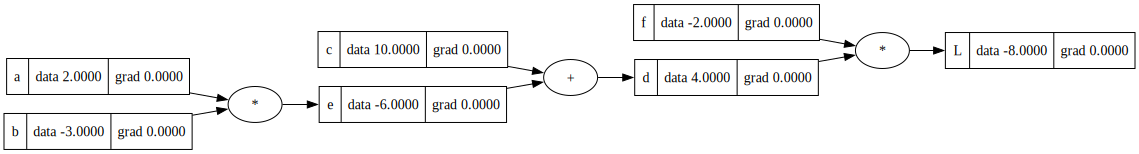

In [239]:
draw_dot(L)

### Manual BACKPROPAGATION

Where grad is basically representing gradient of the output L with respect to a value

L = d * f \
dL/dd =? f \
(f(x+h) - f(x))/h \
So incrementing d by h gives us: \
((d + h)*f - d*f)/h \
= (d*f + h*f - d*f)/h \
= f \
So dl/dd ss basically value of f which is -2 in this example


Similarly dL/df = d which is 4 in this example

In [240]:
# Manual backpropagation
L.grad = 1.0 # as dL/dL = 1.0
d.grad = -2.0
f.grad = 4.0

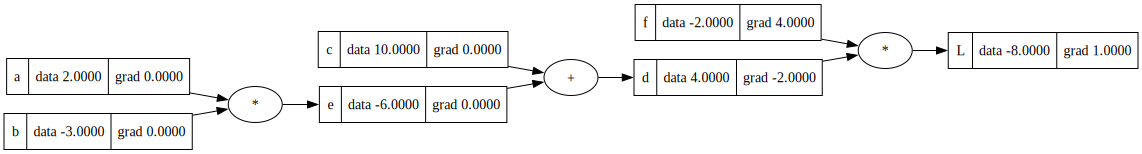

In [241]:
draw_dot(L)

Now that we have calculated grad of d and f, let's calculate grad of e and c i.e dL/dc and dL/de where e + c = d \

We already know dL/dd which tells how L is sensitive to d. \
But how is L sensitive to c? \
So we know how c impacts d, and we know how d impacts f \
So somehow we should be able to put this info together and find how dL/dc

dd / dc ? 1.0 \
d = c + e \
(f(x+h) - f(x)/h) \
= ((c+h + e) - (c + e)/h) \
= 1 \
Therefore, dd/dc = 1.0 \
Similarly, dd/de = 1.0


Now that we know how c affects d and how d affects L, so by chain rule: \
dL/dc = (dL/dd) * (dd/dc) - chain rule \
= -2.0 * 1.0 \
= -2.0


Similarly, dL/de = dL/dd * dd/de \
= -2.0 * 1.0 \
= -2.0

In [242]:
e.grad = -2.0
c.grad = -2.0

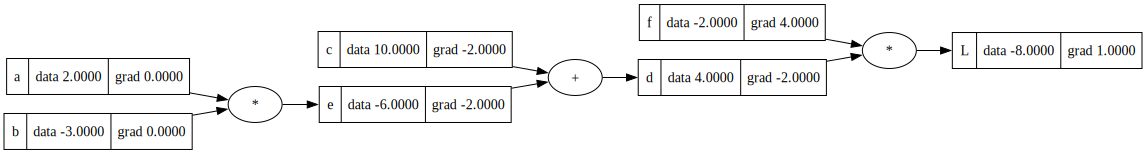

In [243]:
draw_dot(L)

Now let's reverse our way back to a and b to find out dL/da and dL/db 

dL/de = -2.0 \
dL/da = (dL/de) * (de/da) 

e = a * b\
Therefore, de/da = b which is -3.0 \
Similarly, de/db = a which is 2.0



In [244]:
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

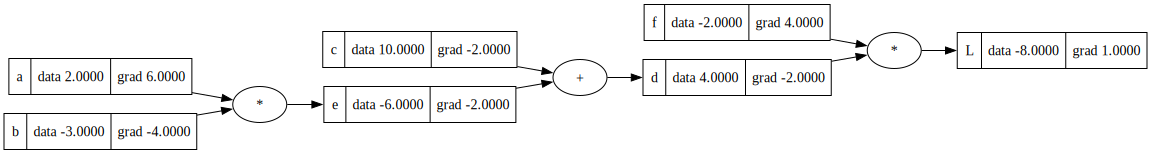

In [245]:
draw_dot(L)

### SUMMARY:

We just recursively multiply the local derivatives and that's what backpropagation is

In [246]:
def lol():

    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    # Incrementing any or many value by h to check how it affEcts the final value
    a = Value(2.0, label='a')
    # a.data += h
    b = Value(-3.0, label='b')
    # b.data += h
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    # e.data += h
    d = e + c; d.label = 'd'
    # d.data += h
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data + h

    print((L2 - L1)/h)

lol()

1.000000000000334


#### Okay Great! Now let's understand backpropagation in a Neural Network as that's what I am ultimately going to build

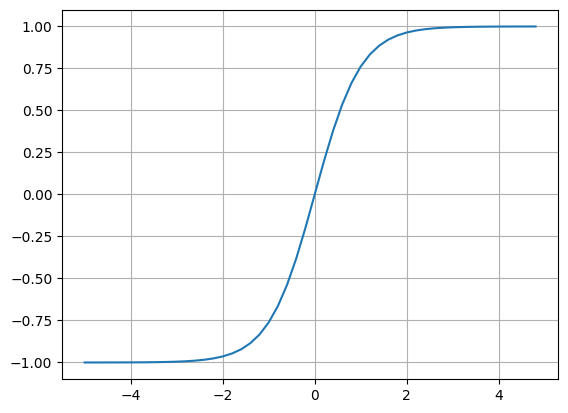

In [247]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid()

In [248]:
class Value:

    def __init__(self,data, _children=(), _op='', label=''): # _children is a list of children and by default is an empty tuple
        self.data = data
        self.grad = 0
        self._prev = set(_children) # for efficiency we will store the children in a set
        self._op =  _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    # similarly we can define other operation like __mul__
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
    # Define the tanh function
    def tanh(self):
        x = self.data
        # tanh is (e^2x - 1)/(e^2x + 1)
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        return out



In [249]:
# Let's build a simple single neuron

# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
# draw_dot(n)

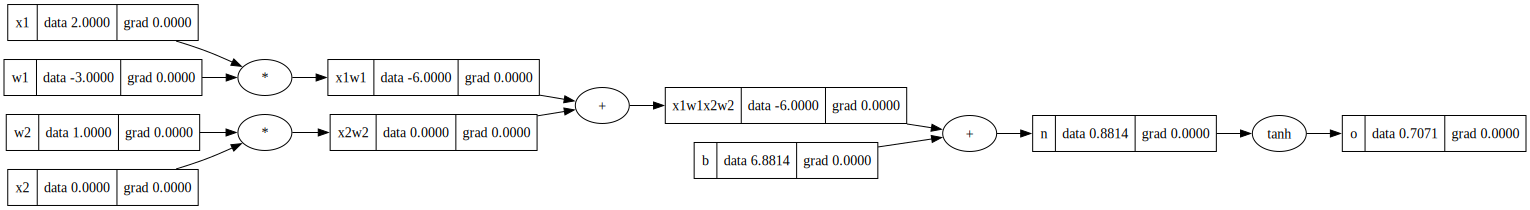

In [250]:
draw_dot(o)

In [251]:
o.grad = 1.0

So in order to backpropagate through tanh, we need to know the local derivative of tanh, i.e derivative of O(output) w.r.t tanh

In [252]:
# o = tanh(n)
# do/dn = 1 - tanh^2(n)
#       = 1 - o^2
1 - o.data**2

0.4999999999999999

In [253]:
# Therefore
n.grad = 0.5

Now n's CHILD ARE CONNECTED through a "+", which is basically a distributor of derivative. So the gradient will flow to both of these child equally

In [254]:
# Therefore:
x1w1x2w2.grad = 0.5
b.grad = 0.5

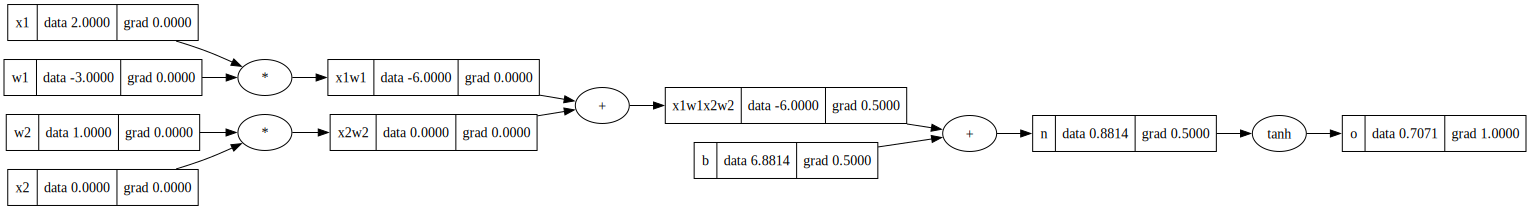

In [255]:
draw_dot(o)

Similarly x1w1x2w2 child's are connected through a "+", So gradient will flow to both child equally 

In [256]:
x1w1.grad = 0.5
x2w2.grad = 0.5

Now coming to x2w2 children

In [257]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
# Above is the local piece of chain rule

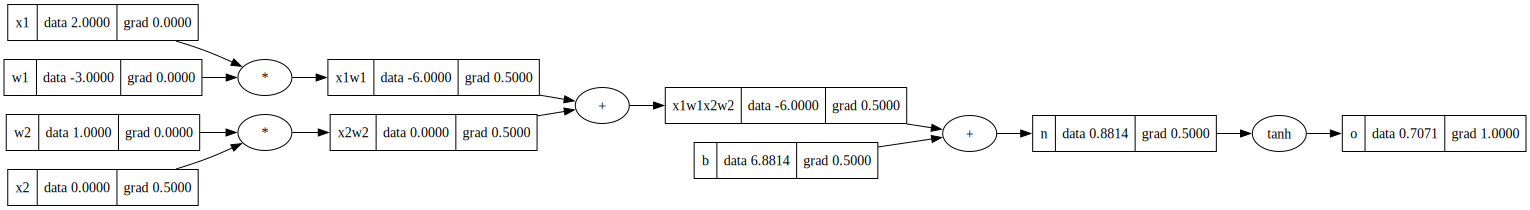

In [258]:
draw_dot(o)

![Forward Pass and Backpropagation](Images/Backpropgist.png)

In [259]:
# SImilarly
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

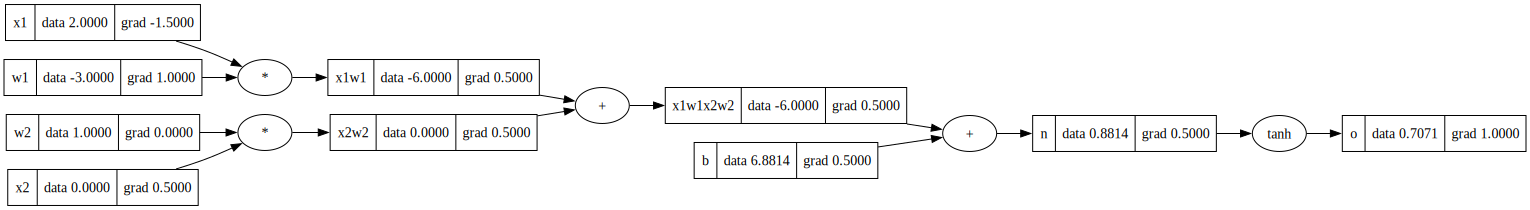

In [260]:
draw_dot(o)

Ofcoursee we are not going to do this backpropagation manually

In [261]:
class Value:

    def __init__(self,data, _children=(), _op='', label=''): # _children is a list of children and by default is an empty tuple
        self.data = data
        self.grad = 0
        self._backward = lambda: None # By default it is an empty function
        self._prev = set(_children) # for efficiency we will store the children in a set
        self._op =  _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            # doing += as gradient needs to be accumulated (multivariate chain rule)
            # if we do =, then it will be overwritten, example in b = a + a + a, b.grad will be 1.0, 
            # but it should be 3.0, This is because all a's are same object

        out._backward = _backward
        return out
    
    # similarly we can define other operation like __mul__
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            # That's what we have been doing manually till now
        
        out._backward = _backward

        return out
    
    # Define the tanh function
    def tanh(self):
        x = self.data
        # tanh is (e^2x - 1)/(e^2x + 1)
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        # we are storing the function not callling it, as that will return NONE
        
        return out



In [262]:
# Let's build a simple single neuron

# inputs x1 and x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
# draw_dot(n)

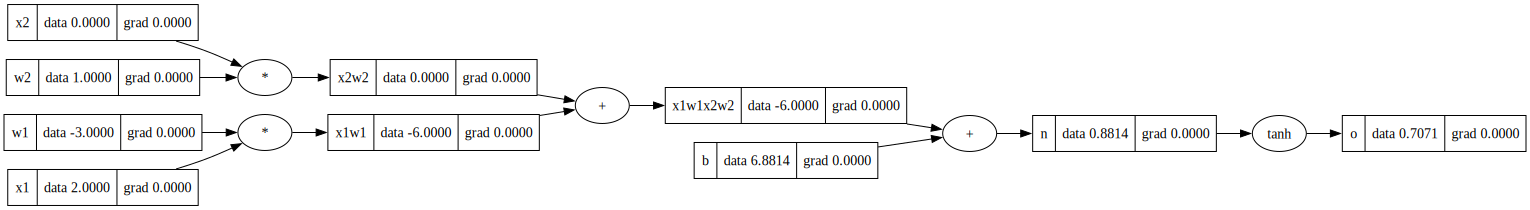

In [263]:
draw_dot(o)

In [264]:
o.grad = 1.0

In [265]:
o._backward()

In [266]:
n._backward()

In [267]:
b._backward()

In [268]:
x1w1x2w2._backward()

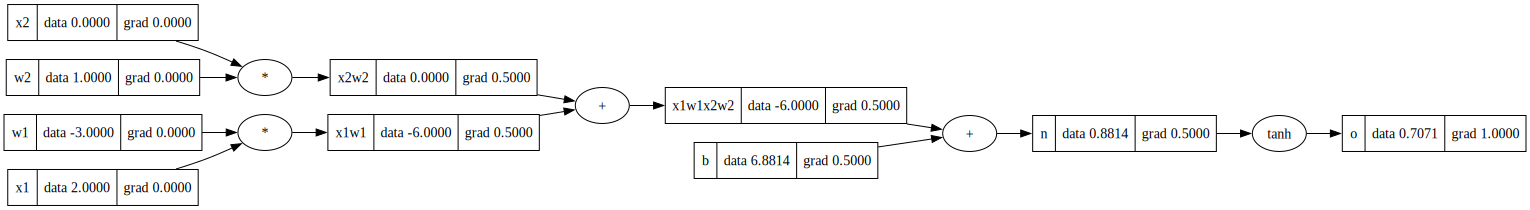

In [269]:
draw_dot(o)

In [270]:
x2w2._backward()
x1w1._backward()

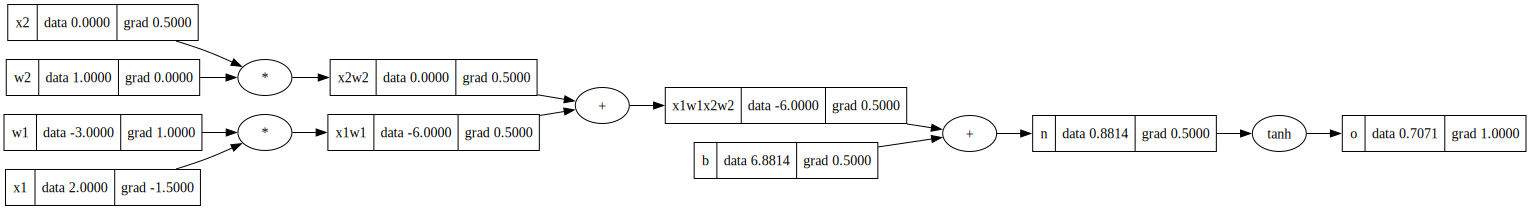

In [271]:
draw_dot(o)

But we are still calling _backward() manually

We can use topological sort for ordering of our graph
- Topological sort is basically laying of graph from left to right

In [272]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

        
    

[Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [273]:
# o.grad = 1.0

# topo = []
# visited = set()
# def build_topo(v):
#     if v not in visited:
#         visited.add(v)
#         for child in v._prev:
#             build_topo(child)
#         topo.append(v)
# build_topo(o)
# topo

# for node in reversed(topo):
#     node._backward()

        
    

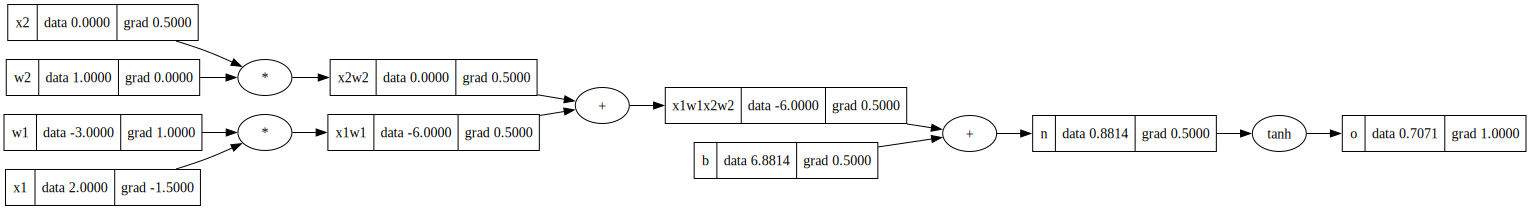

In [274]:
draw_dot(o)

We can put the above code in Value Class itself

In [275]:
class Value:

    def __init__(self,data, _children=(), _op='', label=''): # _children is a list of children and by default is an empty tuple
        self.data = data
        self.grad = 0
        self._backward = lambda: None # By default it is an empty function
        self._prev = set(_children) # for efficiency we will store the children in a set
        self._op =  _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            # doing += as gradient needs to be accumulated (multivariate chain rule)
            # if we do =, then it will be overwritten, example in b = a + a + a, b.grad will be 1.0, 
            # but it should be 3.0, This is because all a's are same object

        out._backward = _backward
        return out
    
    # similarly we can define other operation like __mul__
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            # That's what we have been doing manually till now
        
        out._backward = _backward

        return out
    
    # Define the tanh function
    def tanh(self):
        x = self.data
        # tanh is (e^2x - 1)/(e^2x + 1)
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        # we are storing the function not callling it, as that will return NONE

        return out
    
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [276]:
o._backward()

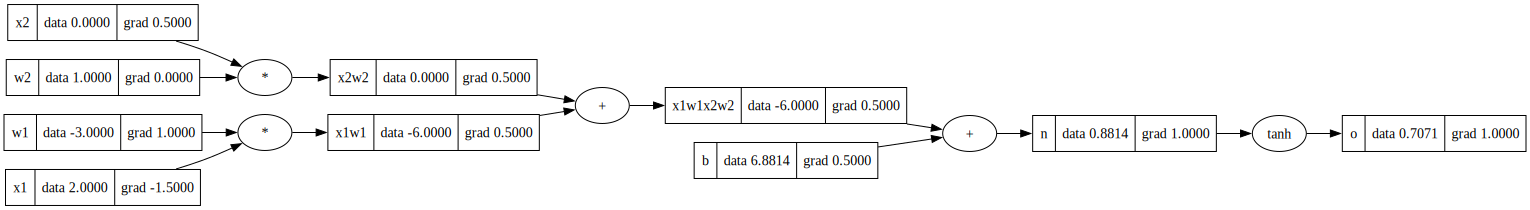

In [277]:
draw_dot(o)

I think I have created a mess! Time to change Notebook